# Experiment 1: F-Pointnet

In this experiment, we evaluate the ensembles approach on the task of missclassification detection on F-Pointnet. We compare it with the approach of Cheng et al. Note that here missclassification means either a wrong class, or an IOU below the threshold.

### Imports

In [1]:
import numpy as np
import pickle
import tqdm

# sklearn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# own modules
import utils.ensemble_utils as ens_utils
import utils.fpointnet_utils as fpointnet_utils
import utils.cheng as cheng
import utils.metrics as metrics
import utils.plots as myplots

### Params

In [2]:
# params
layer_sizes = [256]
n_classes = 7 # these are not classes, but number of regressed box coordinates

## Setting

We apply the ensemble approach on the penultimate layer of the box-regression subnet of F-Pointnet. Each ensemble tries to predict the 7 box coordinates (position, size, and rotation). To evaluate uncertainty, we consider the prediction variance on some box coordinate, here $x$. We then relate the missclassification detections from these uncertainty score. We compare our approach with Cheng et. al. approach. Misclassification here means a low IOU with the ground truth. We train on the training set and evaluate on the validation set. 

Running the full approach requires access to the KITTI dataset, which is quite large. To ease reproducibility, we have extracted the F-Pointnet intermediate activations and outputs on the training and validation data, and provide them in pickle files. In case KITTI is available, we have included our pretrained F-pointnet, as well as methods to extract these values (see respective scripts for details).

![title](figs/approach.png)

## Load F-Pointnet data (activations - outputs)

Here, we load the stored intermediate activations and outputs of F-Pointnet, and compute the IOU values to the ground truth boxes.

In [4]:
#collect training and valid activations
# collect training activ

with open('data/f_pointnet_eval/evaldict_train.pkl', 'rb') as handle:
    evaldict_train = pickle.load(handle)
    
with open('data/f_pointnet_eval/evaldict_val.pkl', 'rb') as handle:
    evaldict_val = pickle.load(handle)
    
# training eval data
A = np.empty((0, 256)) # activations array
Ares = np.empty(0) # ious with ground truth

# test eval data
B = np.empty((0, 256)) # activations array
Bres = np.empty(0) # ious with ground truth

train_boxes = np.zeros((13072, 7))
val_boxes = np.zeros((13004, 7))

cnt = 0

for img_key in tqdm.tqdm(evaldict_train):
    for bbox_dict in evaldict_train[img_key]:
        # get pattern
        patt = bbox_dict['patt']
        A = np.vstack((A, patt))
        # get box info
        pred_center_BboxNet = bbox_dict["pred_center_BboxNet"]
        x_pr, y_pr, z_pr = pred_center_BboxNet
        gt_center = bbox_dict["gt_center"]
        x_gt, y_gt, z_gt = gt_center
        
        pred_h = bbox_dict["pred_h"]
        pred_w = bbox_dict["pred_w"]
        pred_l = bbox_dict["pred_l"]
        pred_r_y = bbox_dict["pred_r_y"]
        gt_h = bbox_dict["gt_h"]
        gt_w = bbox_dict["gt_w"]
        gt_l = bbox_dict["gt_l"]
        gt_r_y = bbox_dict["gt_r_y"]
        # build boxes
        box_pred = np.array([x_pr, y_pr, z_pr, pred_l, pred_w, pred_h, pred_r_y])
        train_boxes[cnt] = box_pred
        cnt += 1
        box_gt = np.array([x_gt, y_gt, z_gt, gt_l, gt_w, gt_h, gt_r_y])
        # calc 3D iou
        iou = fpointnet_utils.iou_3Dbox(box_pred, box_gt)
        Ares = np.hstack((Ares, iou))

# collect val activations
        
cnt = 0

for img_key in tqdm.tqdm(evaldict_val):
    for bbox_dict in evaldict_val[img_key]:
        # get pattern
        patt = bbox_dict['patt']
        B = np.vstack((B, patt))
        # get box info
        pred_center_BboxNet = bbox_dict["pred_center_BboxNet"]
        x_pr, y_pr, z_pr = pred_center_BboxNet
        gt_center = bbox_dict["gt_center"]
        x_gt, y_gt, z_gt = gt_center
        
        pred_h = bbox_dict["pred_h"]
        pred_w = bbox_dict["pred_w"]
        pred_l = bbox_dict["pred_l"]
        pred_r_y = bbox_dict["pred_r_y"]
        gt_h = bbox_dict["gt_h"]
        gt_w = bbox_dict["gt_w"]
        gt_l = bbox_dict["gt_l"]
        gt_r_y = bbox_dict["gt_r_y"]
        # build boxes
        box_pred = np.array([x_pr, y_pr, z_pr, pred_l, pred_w, pred_h, pred_r_y])
        val_boxes[cnt] = box_pred
        cnt += 1
        box_gt = np.array([x_gt, y_gt, z_gt, gt_l, gt_w, gt_h, gt_r_y])
        # calc 3D iou
        iou = fpointnet_utils.iou_3Dbox(box_pred, box_gt)
        Bres = np.hstack((Bres, iou))

100%|██████████████████████████████████████████████████████████████████████████████| 3405/3405 [01:30<00:00, 37.51it/s]


## Apply Cheng's approach

Now that we have the intermediate activations and IOUs, we can apply Cheng's approach, by converting the problem to classification (low IOU -> wrong "class", etc.). We use utilities to compute the respective Hamming distances, etc. A summary of Cheng's approach can be seen in the Figure below.

![title](figs/cheng.png)

In [5]:
# get activ patterns for cheng's approach
Apatt = cheng.Patt(A)

# make hamming dists (for Cheng's approach)
X = np.zeros_like(Bres)

for i in tqdm.tqdm(range(len(X))):
    # get patt
    patt = cheng.Patt (B[i])
    # get hamm dist
    d = cheng.minHamdist(patt, Apatt) / 256
    X[i] = d

# run cheng
# real "labels" Y - which boxes have low IOU
iou_thres = 0.5
Y_val = Bres < iou_thres

# Cheng's Y pred - samples with high Hamming dist are missclassified
ham_thres = 0.03 # approx. best threshold found
Y_pred = X > ham_thres

# print det. error, FAR and F1
det_err_cheng, far_cheng, F1_cheng = metrics.printMeasures(Y_pred, Y_val)

100%|███████████████████████████████████████████████████████████████████████████| 13004/13004 [01:59<00:00, 108.60it/s]


## Apply Ensembles

Now we can also run the ensembles approach. Ech ensemble member tries to predict the Box coordinates. Then, we consider as "bad" the boxes that have high prediction variance (with respect to the "correct" boxes of the training set).

In [6]:
#run ensembles
lay = 0

# define base classifier
clf_base = make_pipeline(StandardScaler(), MLPRegressor(random_state=1, hidden_layer_sizes=(), max_iter=10))

n_clfs = 10 # 10
portion = 0.8

# good cases - bbox has overlap higher than iou threshold
idx = Ares >= iou_thres
Anew = A[idx]
train_boxes_new = train_boxes[idx]

# rest cases - misses
Arest = A[~idx]
train_boxes_rest = train_boxes[~idx]

# train
# train all clfs
clfs_list = ens_utils.train_all_classifiers_reg(n_clfs, clf_base, Anew, train_boxes_new, lay, layer_sizes, portion)

# test all clfs
Ypred_ind, Ypred_ood = ens_utils.test_all_classifiers_reg(clfs_list, Anew, train_boxes_new, Arest, train_boxes_rest, n_classes, lay, layer_sizes)

# all ood out
_, Ypred_ood2 = ens_utils.test_all_classifiers_reg(clfs_list, Anew, train_boxes_new, B, val_boxes, n_classes, lay, layer_sizes)


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
 10%|████████▎                                                                          | 1/10 [00:00<0

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.14it/s]


### Measure Performance

Now, we can measure performance

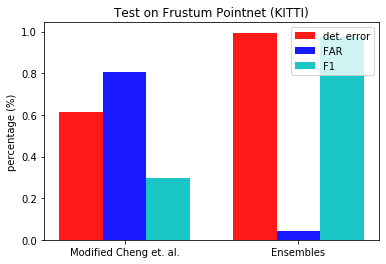

In [7]:
# measure performance
# get threshold for variance as thr = mean[var] + 3std[var] on training set
S = np.std(Ypred_ind, axis = 2)
S2 = np.std(Ypred_ood, axis = 2)
S3 = np.std(Ypred_ood2, axis = 2)
n_feat = 0

thres = S[:,0].mean() + 3*S[:,0].std()

ypred = S3[:, 0] <= thres
ytest = Bres >= iou_thres

det_err_ens, far_ens, F1_ens = metrics.printMeasures(ypred, ytest)

# make plot
DET_ERR_ALL = (det_err_cheng, det_err_ens)
FAR_ALL = (far_cheng, far_ens)
F1_ALL = (F1_cheng, F1_ens)

myplots.make_barplot([DET_ERR_ALL, FAR_ALL, F1_ALL], 
                     'Test on Frustum Pointnet (KITTI)', ['Modified Cheng et. al.', 'Ensembles'], 
                     ['det. error', 'FAR', 'F1'])